# Experiments for Masters's Program in Business Informatics University of Mannheim
This notebook contains the experiments performed on the Masters's program in business informatics at the University of Mannheim

## 1. Imports

In [1]:
import camelot
import pandas as pd
import tableExtraction as te
import graphCreation as gc
import re
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3

## 2. Create Graph
### 2.1 Extract Course Tables from Module Handbooks

In [2]:
relevant_courses = te.get_relevant_courses("../02_Ressources/MK_MSc_Wifo_neue_PO_2020_21_CourseOverview.pdf")
courses = te.get_courses("../02_Ressources/MK_MSc_Wifo_neue_PO_2020_21_Courses.pdf")


paths = ["../02_Ressources/Modulkatalog_MMM_Deutsch_abHWS2020.pdf"]
end_cells = [r"Range of application|Verwendbarkeit"]
coordinates = [[0,0]]
bwl_range = [["ACC", "TAX", "FIN", "MAN", "MKT", "OPM"], ["5", "6"]]
courses.extend(te.get_additional_courses(relevant_courses, paths, end_cells, coordinates, bwl_range))
#courses_BWL = te.get_additional_courses(relevant_courses, paths, end_cells, coordinates, bwl_range)

KeyboardInterrupt: 

courses = te.post_fixes(courses)

index = 0
for course in courses:
    name = "../03_Courses/" + "Course" + str(index) + ".xlsx"
    course.to_excel(name, index=False)
    index += 1

In [2]:
#import courses

courses = []
for i in range(0,171):
    path = "../03_Courses/Course" + str(i) + ".xlsx"
    df = pd.read_excel(path, dtype=str).fillna('')
    courses.append(df)

### 2.2 Creation of Nodes & Edges

In [3]:
G = nx.DiGraph()

course_nodes = gc.getCourseNodes(courses)
knowledge_nodes = pd.read_excel("../04_Graph/knowledgeAreas.xlsx").values.tolist()
edges_df = pd.read_excel("../04_Graph/edges.xlsx")
edges = edges_df.values.tolist()

In [4]:
#Create Course Nodes
for node in course_nodes:
    G.add_node(node[0], ECTS=node[1], offering_cycle=node[2], color="grey", type="course", active = False)

#Create Skill Nodes
for i in range(len(knowledge_nodes)):
    if i <= 16:
        G.add_node(knowledge_nodes[i][0], color="blue", type="skill", active = False)
    elif i > 16 and i <= 22:
        G.add_node(knowledge_nodes[i][0], color="green", type="skill", active = False)
    else:
        G.add_node(knowledge_nodes[i][0], color="brown", type="skill", active = False)

names = []

In [5]:
#Load manually created course -> skill edges
for edge in edges:
   G.add_edge(edge[0], edge[1], active = False)

additional_edges, additional_nodes = gc.complete_edges(courses, edges_df)

for node in additional_nodes:
    G.add_node(node[0], color = node[1], type = node[2], subtype = node[3], amount = node[4], active = False)

for edge in additional_edges:
    if len(edge) <= 2:
        G.add_edge(edge[0], edge[1], active = False)
    else:
        G.add_edge(edge[0], edge[1], weight = edge[2], active = False)

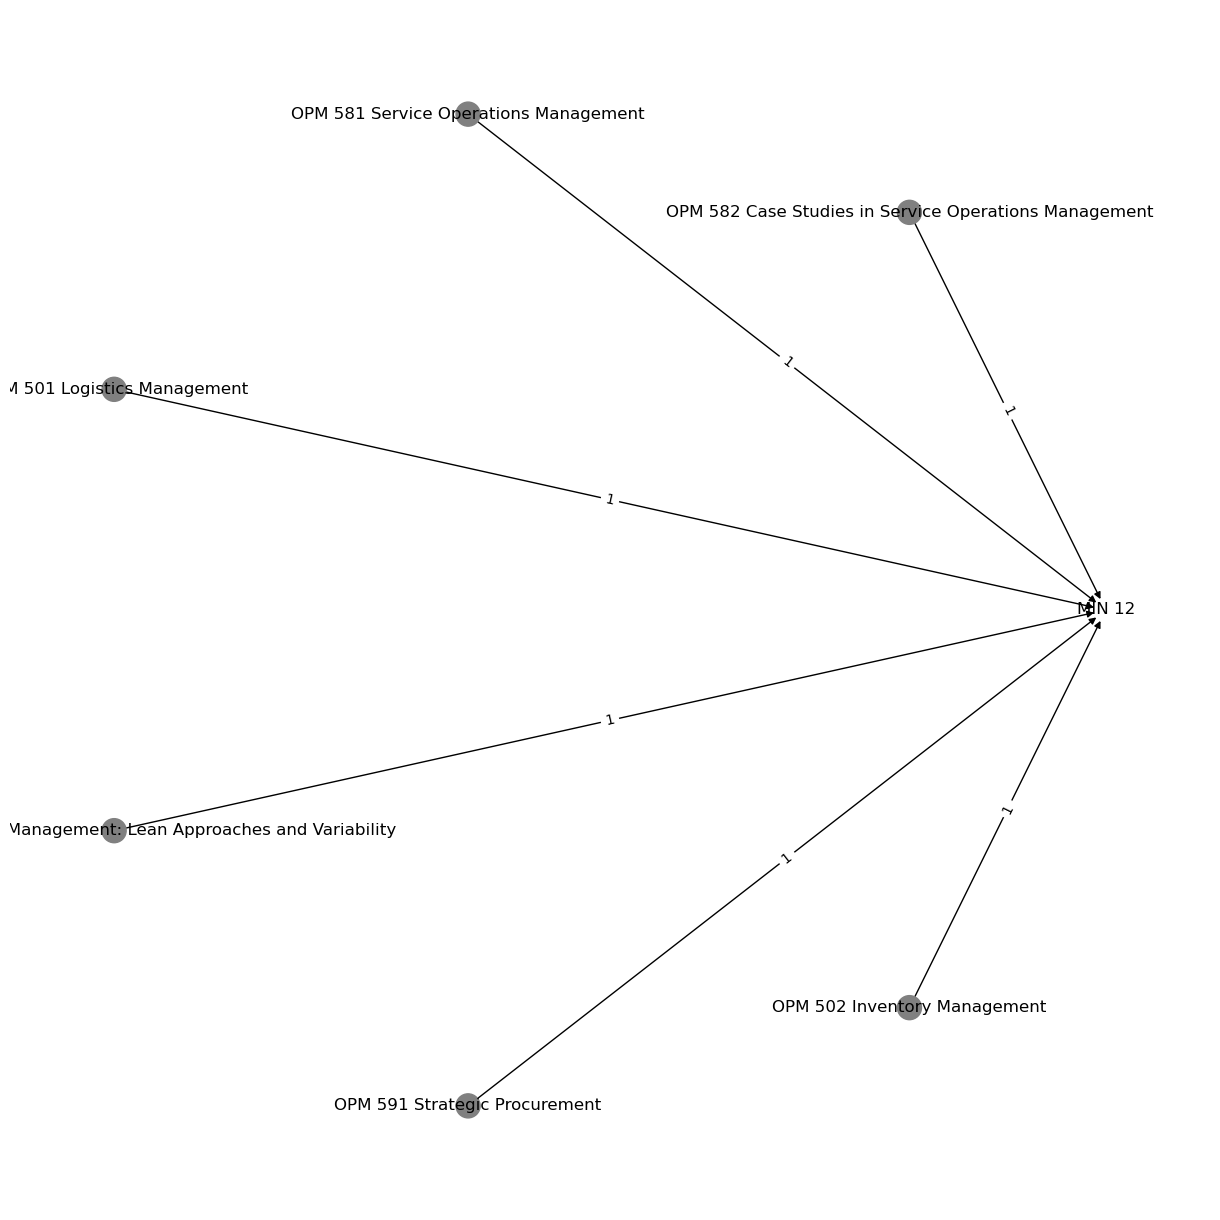

In [6]:
# Get Min Nodes for parallel attendance
node_id = 'OPM 601 Supply Chain Management'  
node_id = 'OPM 661 Business Analytics: Robust Planning in Stochastic Systems'  
node_id = 'OPM 682 Revenue Management'  
node_id = 'MIN 12'  

incoming_nodes = [n for n in G.predecessors(node_id)]  
subgraph_nodes = set([node_id] + incoming_nodes)
subgraph = G.subgraph(subgraph_nodes)

pos = nx.circular_layout(subgraph)
plt.figure(figsize=(12, 12))
node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)

edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

plt.show()

In [7]:
#Set weights for parallel prerequisite course dependency
G.edges["FIN 540 Corporate Finance I - Lecture (Capital Structure, Cost of Capital and Valuation)",
"FIN 541 Corporate Finance I - Case Study (Capital Structure, Cost of Capital and Valuation)"]["weight"] = 2

G.edges["IS 512 IT Management in the Digital Age", "IS 513 Applied IT Management in the Digital Age"]["weight"] = 2

G.edges["IS 615 Design Thinking and Lean Development in Enterprise Software Development", 
"IS 613 Applied Project in Design Thinking and Lean Software Development"]["weight"] = 2

G.edges["MIN 10", "OPM 601 Supply Chain Management"]["weight"] = 2

G.edges["MIN 11", "OPM 661 Business Analytics: Robust Planning in Stochastic Systems"]["weight"] = 2

G.edges["MIN 12", "OPM 682 Revenue Management"]["weight"] = 2

In [8]:
#Add complex prerequisite dependencies

#ACC 626 
G.add_node("MIN 13", color = "white", type = "prerequisite", subtype = "MIN", amount = 1, active = False)
G.add_node("MIN 14", color = "white", type = "prerequisite", subtype = "MIN", amount = 2, active = False)
G.add_edge("MIN 13", "ACC 626 Transaction Accounting", weight = 1, active = False)
G.add_edge("ACC 520 IFRS Accounting and Capital Markets", "MIN 13", weight = 1, active = False)
G.add_edge("ACC 530 Group Accounting", "MIN 13", weight = 1, active = False)
G.add_edge("MIN 14", "MIN 13", weight = 1, active = False)
G.add_edge("ACC 510 Jahresabschluss", "MIN 14", weight = 1, active = False)
G.add_edge("ACC 540 Financial Statement Analysis & Equity Valuation", "MIN 14", weight = 1, active = False)
G.add_edge("ACC 560 Managerial Accounting", "MIN 14", weight = 1, active = False)

#ACC 628 
G.add_node("MIN 15", color = "white", type = "prerequisite", subtype = "MIN", amount = 1, active = False)
G.add_node("MIN 16", color = "white", type = "prerequisite", subtype = "MIN", amount = 2, active = False)
G.add_edge("MIN 15", "ACC 628 Selected Issues in IFRS Accounting", weight = 1, active = False)
G.add_edge("ACC 520 IFRS Accounting and Capital Markets", "MIN 15", weight = 1, active = False)
G.add_edge("MIN 16", "MIN 15", weight = 1, active = False)
G.add_edge("ACC 510 Jahresabschluss", "MIN 16", weight = 1, active = False)
G.add_edge("ACC 530 Group Accounting", "MIN 16", weight = 1, active = False)
G.add_edge("ACC 540 Financial Statement Analysis & Equity Valuation", "MIN 16", weight = 1, active = False)
G.add_edge("ACC 560 Managerial Accounting", "MIN 16", weight = 1, active = False)

#ACC 632 
G.add_node("MIN 17", color = "white", type = "prerequisite", subtype = "MIN", amount = 1, active = False)
G.add_node("MIN 18", color = "white", type = "prerequisite", subtype = "MIN", amount = 2, active = False)
G.add_edge("MIN 17", "ACC 632 Konzernrechnungslegungspraxis", weight = 1, active = False)
G.add_edge("ACC 530 Group Accounting", "MIN 17", weight = 1, active = False)
G.add_edge("MIN 18", "MIN 17", weight = 1, active = False)
G.add_edge("ACC 510 Jahresabschluss", "MIN 18", weight = 1, active = False)
G.add_edge("ACC 520 IFRS Accounting and Capital Markets", "MIN 18", weight = 1, active = False)
G.add_edge("ACC 540 Financial Statement Analysis & Equity Valuation", "MIN 18", weight = 1, active = False)
G.add_edge("ACC 560 Managerial Accounting", "MIN 18", weight = 1, active = False)

In [9]:
#Quality Checks for Attribute values

for node, data in G.nodes(data=True):
    #print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    print(data.get('offering_cycle'))
    #if not (data.get('offering_cycle') == "FWS" or data.get('offering_cycle') =="SSS" or data.get('offering_cycle') == "Continuously"):
        #print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    #print(f"Knoten {node}: name = {data.get('ECTS')}")

#for outgoing, ingoing, data in G.edges(data=True):
#    print(f"{outgoing} -> {ingoing}: weight = {data.get('weight')}")

#for outgoing, ingoing, data in G.edges(data=True):
#    if "OR 3" in outgoing or "OR 3" in ingoing:
#        print(f"{outgoing} -> {ingoing}: weight = {data.get('weight')}")

FWS
SSS
Continuously
FWS
Continuously
FWS
FWS
Continuously
SSS
FWS
FWS
SSS
FWS
SSS
FWS
FWS
SSS
FWS
SSS
SSS
SSS
FWS
FWS
SSS
FWS
SSS
FWS
Continuously
Continuously
SSS
Continuously
Continuously
Continuously
Continuously
Continuously
SSS
SSS
FWS
FWS
FWS
FWS
Continuously
Continuously
Continuously
SSS
FWS
FWS
SSS
SSS
FWS
SSS
FWS
SSS
SSS
FWS
Continuously
FWS
FWS
SSS
SSS
FWS
FWS
SSS
SSS
FWS
SSS
FWS
FWS
FWS
SSS
FWS
SSS
FWS
FWS
SSS
FWS
SSS
Continuously
FWS
SSS
FWS
SSS
Continuously
SSS
SSS
SSS
SSS
SSS
SSS
SSS
FWS
FWS
SSS
FWS
FWS
FWS
FWS
FWS
FWS
SSS
SSS
Continuously
Continuously
Continuously
Continuously
FWS
FWS
SSS
Continuously
FWS
SSS
SSS
FWS
FWS
SSS
SSS
FWS
SSS
SSS
FWS
FWS
FWS
SSS
SSS
SSS
FWS
SSS
FWS
SSS
SSS
SSS
FWS
FWS
FWS
FWS
SSS
SSS
SSS
SSS
FWS
SSS
FWS
SSS
FWS
FWS
SSS
SSS
SSS
FWS
SSS
SSS
FWS
FWS
FWS
SSS
FWS
SSS
FWS
FWS
SSS
SSS
SSS
FWS
FWS
SSS
FWS
SSS
SSS
FWS
SSS
SSS
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
No

<function matplotlib.pyplot.show(close=None, block=None)>

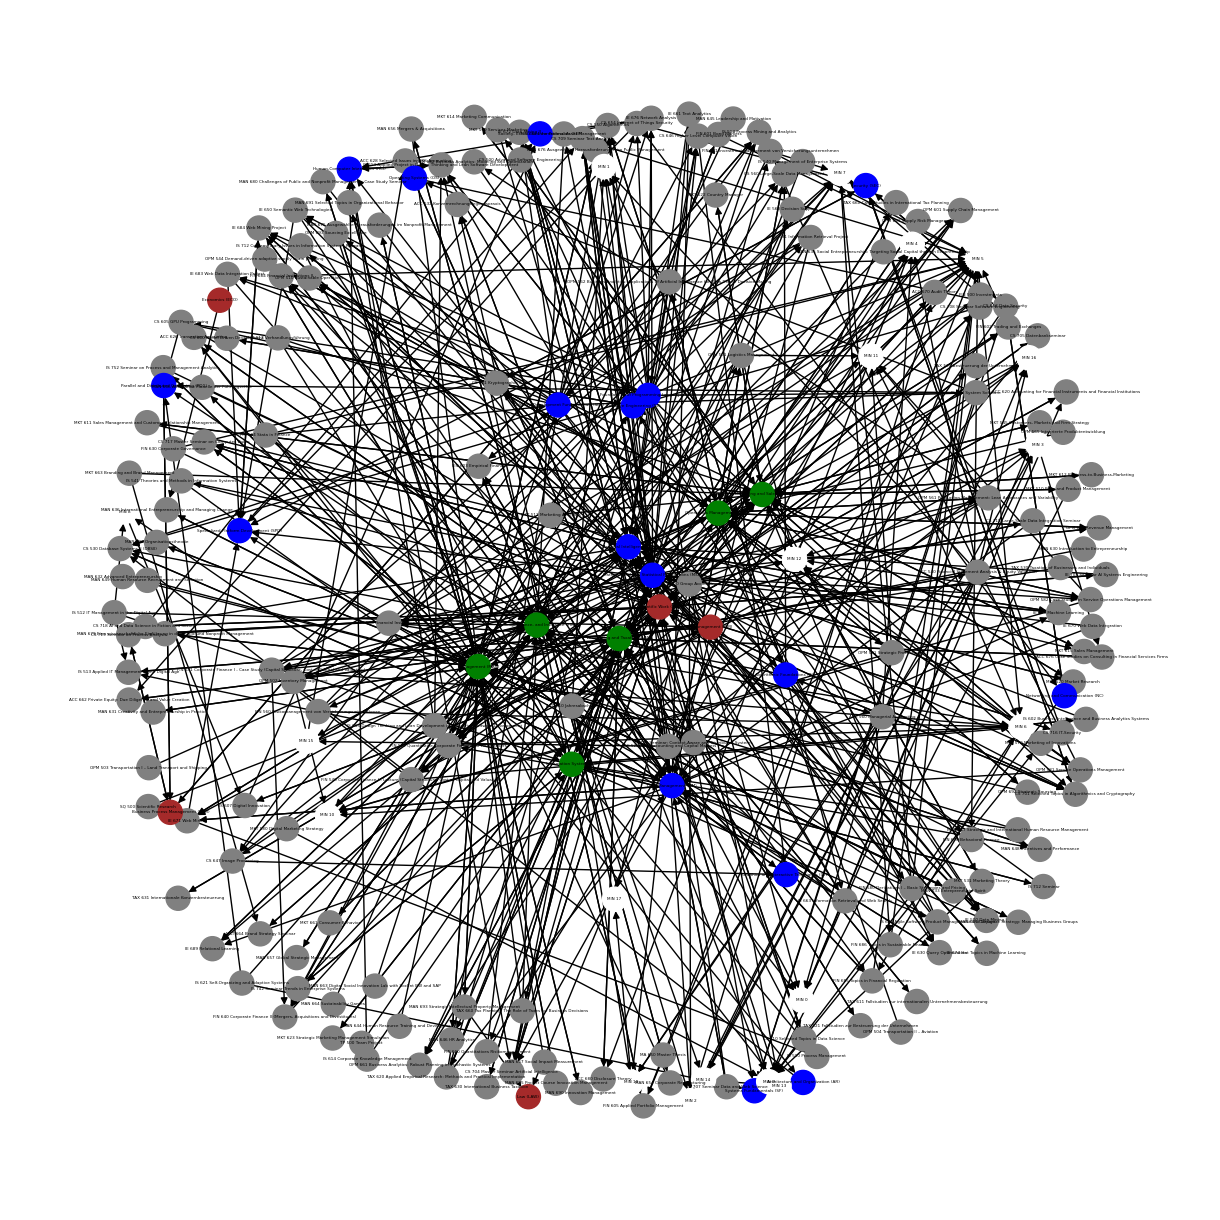

In [10]:
pos = nx.spring_layout(G, k=1) 

plt.figure(figsize=(12, 12))

node_colors = [G.nodes[node]['color'] for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=3)

#nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
plt.savefig("graph.pdf", format="pdf") 
plt.show

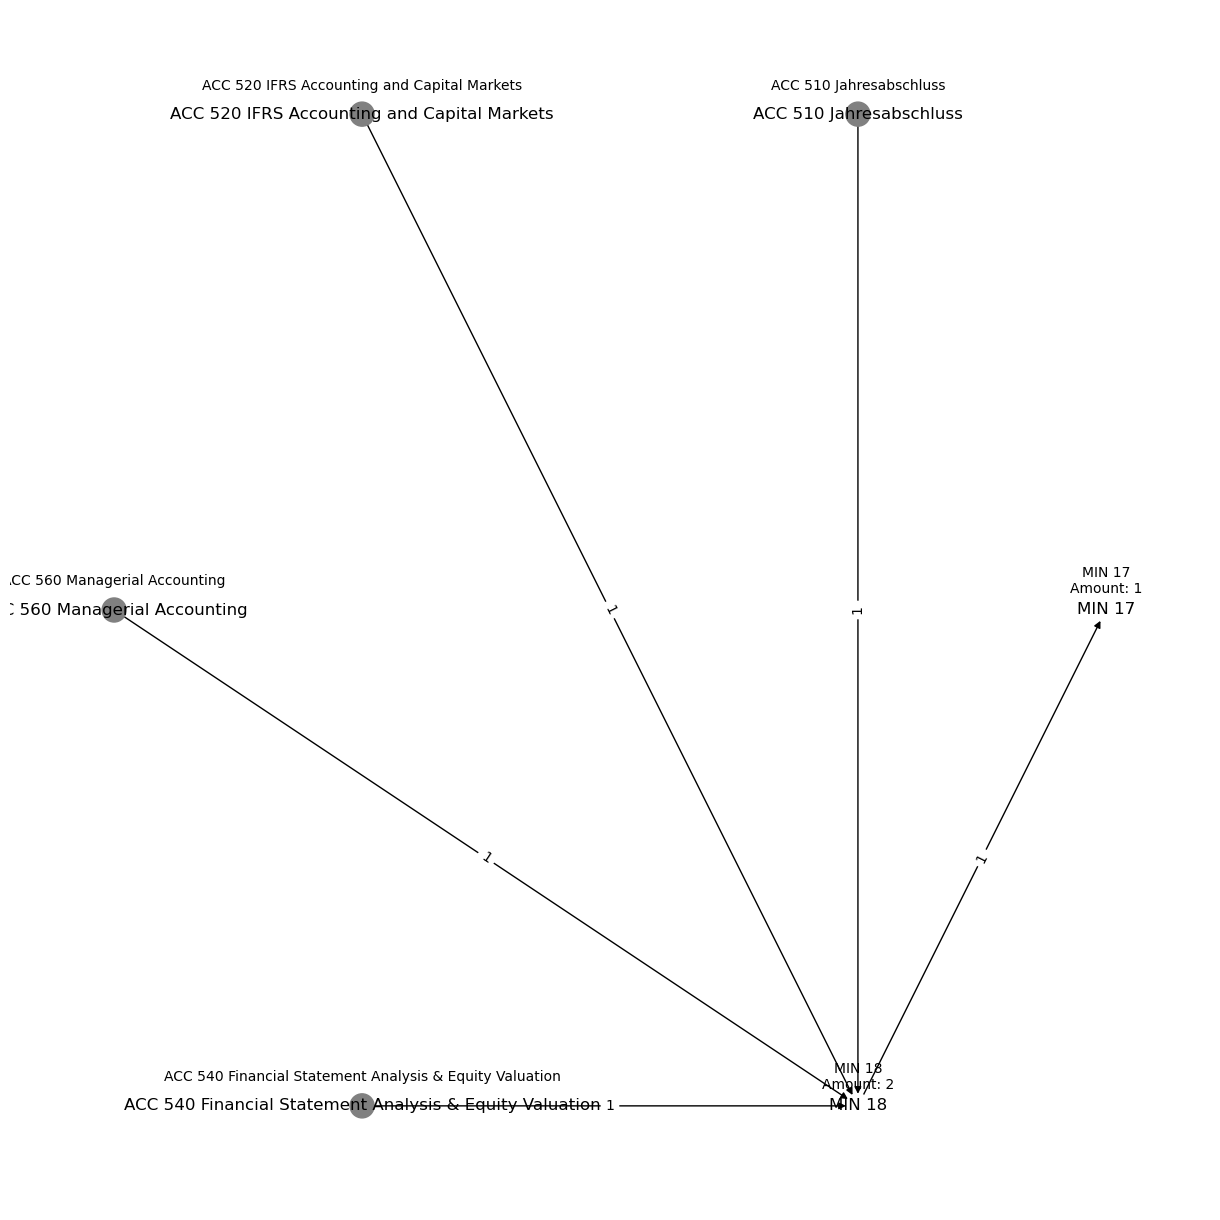

In [11]:
# Wähle den gewünschten Node, z.B. node_id
node_id = 'ACC 510'  # Ersetze 'A' durch die ID des gewünschten Nodes
node_id = "MIN 18"

# Finde die Knoten, die mit dem ausgewählten Knoten verbunden sind (eingehend und ausgehend)
incoming_nodes = [n for n in G.predecessors(node_id)]  # Eingehende Knoten
outgoing_nodes = [n for n in G.successors(node_id)]  # Ausgehende Knoten

# Alle relevanten Knoten: der Knoten selbst, eingehende und ausgehende Nachbarn
subgraph_nodes = set([node_id] + incoming_nodes + outgoing_nodes)
#subgraph_nodes = set([node_id] + outgoing_nodes)
#subgraph_nodes = set([node_id] + incoming_nodes)

# Erzeuge den Subgraphen mit den gefundenen Knoten
subgraph = G.subgraph(subgraph_nodes)

# Positionen der Nodes berechnen (für den Subgraphen)
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(12, 12))

# Farben der Nodes für den Subgraphen
node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]

# Zeichne den Subgraphen
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)

node_labels = {
    node: f"{node}\nAmount: {subgraph.nodes[node]['amount']}" 
    if 'amount' in subgraph.nodes[node] else node
    for node in subgraph.nodes()
}

offset = 0.05  # Verschiebung der Labels; kann angepasst werden
label_pos = {node: (pos[node][0], pos[node][1] + offset) for node in subgraph.nodes()}

# Zeichne die Labels mit den angepassten Positionen
nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10)

edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)


# Speichere das Ergebnis und zeige es an
plt.savefig("subgraph_with_edges.pdf", format="pdf")
plt.show()

### 2.3 Edge Weighting

In [20]:
#Match Course Names between Graph and Database

df_courseNames = pd.read_csv("../02_Ressources/DB_CourseNames.csv")

conn = sqlite3.connect('DB_CourseNames.db')
cursor = conn.cursor()

df_courseNames.to_sql('course_names', conn, if_exists='replace', index=False)

matching_results = []

matching_results_list = []

for course in courses:
    db_courseName = gc.mapGraphToDB_courseName(course)
    graph_courseName = gc.getCourseName(course)
    query = "SELECT kurs, count FROM course_names WHERE ? LIKE kurs || '%'" 
    cursor.execute(query, (db_courseName,))
    results = cursor.fetchall()
    
    results_string_course = ', '.join([str(result[0]) for result in results])
    results_string_count = ', '.join([str(result[1]) for result in results])
    matching_results.append(graph_courseName + " matches: " + results_string)
    matching_results_list.append([graph_courseName, results_string_course, results_string_count])


query = "SELECT kurs FROM course_names" 
cursor.execute(query)
results = cursor.fetchall()
    

#for line in results:
#    print(line[0])

#print("\n")

for course_match in matching_results:
    if not re.match(r".*matches: $", course_match):
        print(course_match)

conn.close()

matching_results_df = pd.DataFrame(matching_results_list, columns=["Graph", "DB", "Count"])
matching_results_df.to_excel("Matching_Results.xlsx", index = False)

CS 500 Advanced Software Engineering matches: CS 500 Advanced Software Engineering
CS 530 Database Systems II (DBSII) matches: CS 500 Advanced Software Engineering
CS 550 Algorithmics matches: CS 500 Advanced Software Engineering
CS 560 Large-Scale Data Management matches: CS 500 Advanced Software Engineering
IE 500 Data Mining I matches: CS 500 Advanced Software Engineering
IE 560 Decision Support matches: CS 500 Advanced Software Engineering
CS 600 Model Driven Development matches: CS 500 Advanced Software Engineering
CS 605 GPU Programming matches: CS 500 Advanced Software Engineering
CS 646 Higher Level Computer Vision matches: CS 500 Advanced Software Engineering
CS 647 Image Processing matches: CS 500 Advanced Software Engineering
CS 651 Kryptographie II matches: CS 500 Advanced Software Engineering
CS 652 Data Security matches: CS 500 Advanced Software Engineering
CS 654 Internet of Things Security matches: CS 500 Advanced Software Engineering
IE 630 Query Optimization matches: 